# 0.0 IMPORTS

In [1]:
import math
import datetime
import inflection

import numpy               as np
import pandas              as pd
import xgboost             as xgb
import matplotlib.pyplot   as plt
import seaborn             as sns
import matplotlib.gridspec as gridspec

from scipy                 import stats     as ss
from boruta                import BorutaPy
from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


## 0.1 Helpers Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
def cramer_v(x,y):

    cm = pd.crosstab( x, y).values
    n = cm.sum()
    r , k = cm.shape

    chi2 = ss.chi2_contingency ( cm )[0]
    chi2corr = max( 0, chi2 - ((k-1)*(r-1))/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
        
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1) ))

In [4]:
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs(( y - yhat ) / y ))

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ))
    
    return pd.DataFrame({ 'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index = [0])

In [65]:
def cross_validation( x_training, kfold, model_name, model, verbose = False ):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold + 1 )):
        if verbose:
            print ('/nKFold Number: {}'.format( k ))
        # start and end date for validation
        validation_start_date = x_training['date'].max() -  datetime.timedelta( days = k*6*7 )
        validation_end_date = x_training['date'].max() -  datetime.timedelta( days = (k-1)*6*7 )

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[( x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset:
         # training
        xtraining = training.drop( ['sales', 'date'], axis = 1 )
        ytraining = training['sales']

         # validation
        xvalidation = validation.drop( ['sales', 'date'], axis = 1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list), 2).astype( str ) + ' +/- ' + np.round(np.std( mae_list), 2).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list), 2).astype( str ) + ' +/- ' + np.round(np.std( mape_list), 2).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list), 2).astype( str ) + ' +/- ' + np.round(np.std( rmse_list), 2).astype( str )}, index = [0])

## 0.2 Loading Data

In [6]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory= False)
df_store_raw = pd.read_csv('data/store.csv', low_memory= False)

# merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 DATA DESCRIPTION

In [7]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# Rename
df1.columns = cols_new

## 1.2 Data Dimentions

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3 Data Types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [12]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else (x))

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply ( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis =1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply ( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis =1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply ( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis =1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply ( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis =1)



In [13]:
# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 
                                                             else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

## 1.6 Change Types

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [16]:
num_attributes = df1.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [17]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - Std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance'>

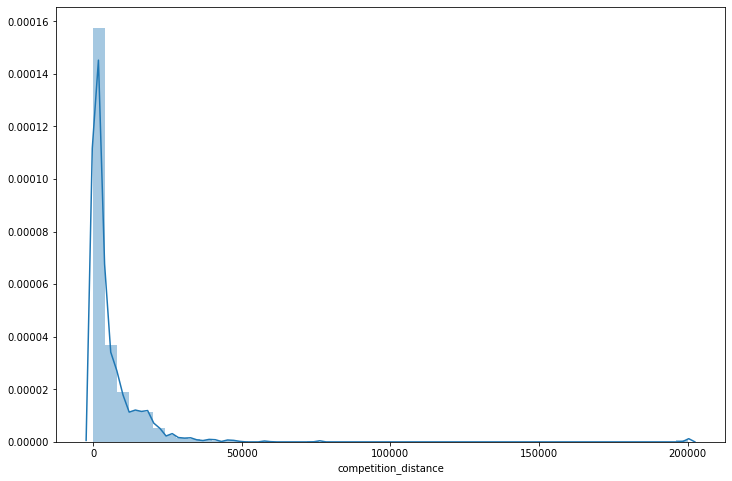

In [18]:
plt.figure(figsize = (12, 8))
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [19]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

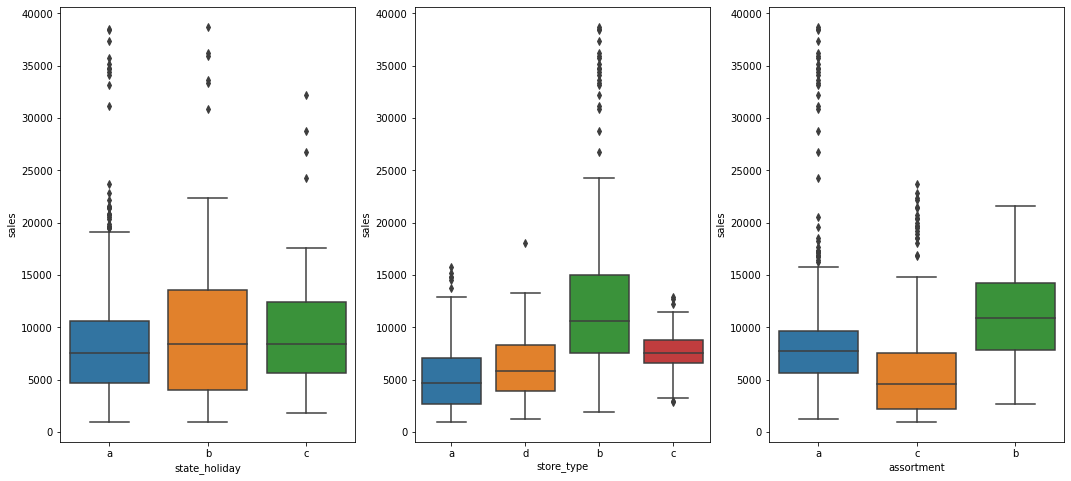

In [20]:
plt.figure(figsize = (18, 8))
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1, )

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1, )

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1, )

# 2.0 FEATURE ENGENEERING

In [21]:
df2 = df1.copy()

## 2.1 Mind Map Hypotheses

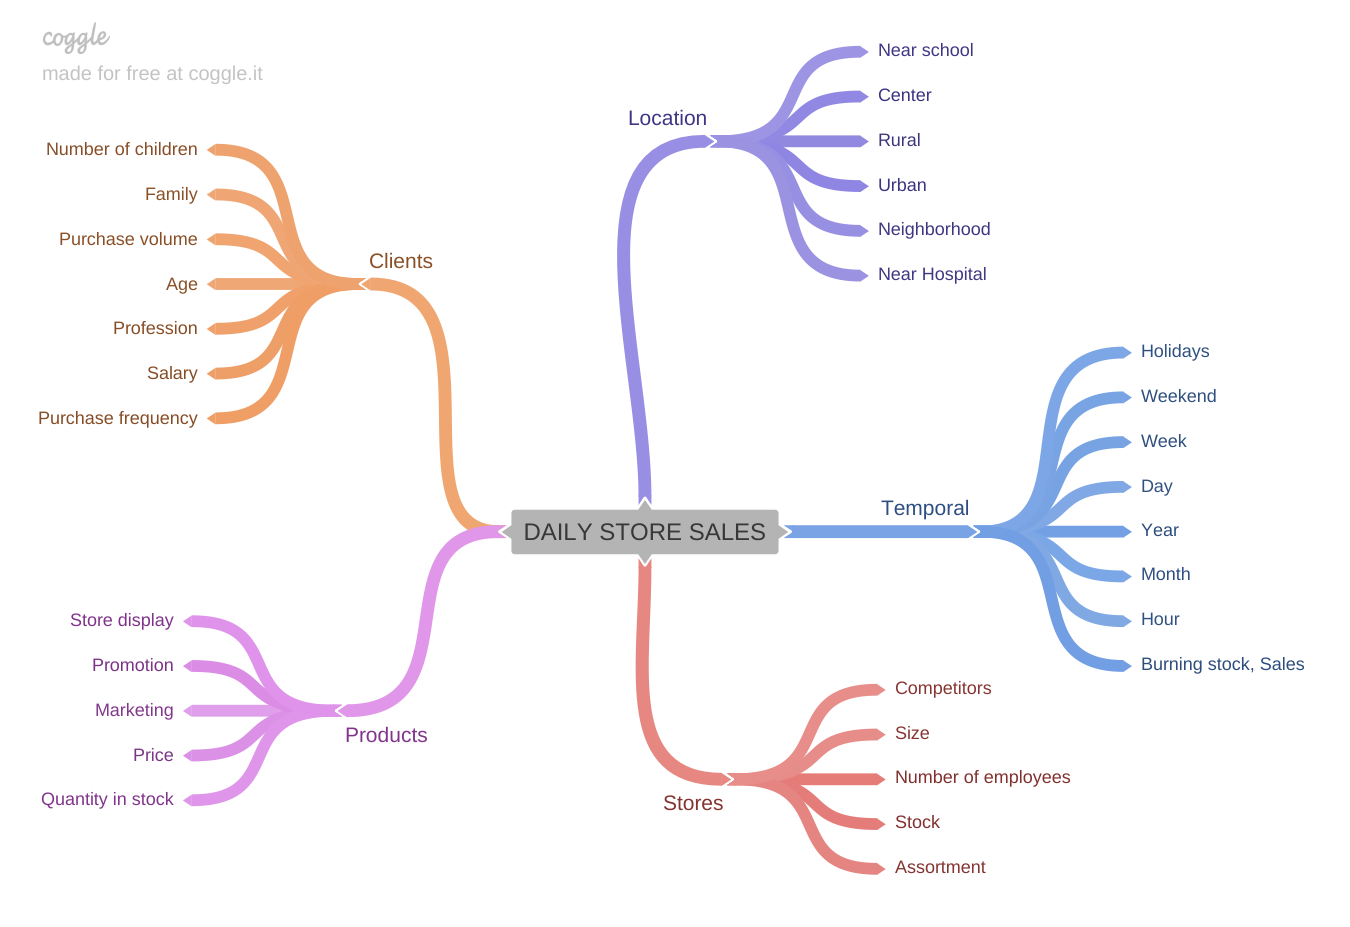

In [22]:
Image ('img/mindmaps.png')

## 2.2 Hypotheses criation

### 2.2.1 Hypotheses Stores

**1.** Stores with more employees should have more sales.

**2.** Stores with more products in stock should have more sales.

**3.** Stores with more assortment should  have more sales.

**4.** Stores with bigger size should  have more sales.

**5.** Stores with closer competitors should sell less.

**6.** Stores with longer competitors should sell more.

**7.** Stores with home delivery should sell more.

### 2.2.2 Hypotheses Clients

**1.** Stores with customers with the largest number of children should have more sales.

**2.** Stores with customers with family should have more sales.

**3.** Stores with older customers should sell more.

**4.** Stores with customers with high-paying jobs should sell more.

**5.** Stores with high purchase frequency per client should sell more.

**6.** Stores ith high purchase volume per client should sell more.

**7.** Stores with more clients should sell more.

### 2.2.3 Hypotheses Products

**1.** Stores with more investment in marketing should have more sales.

**2.** Stores that show more products in showcases should sell more.

**3.** Stores with lower prices should have more sales.

**4.** Higher discount stores should sell more.

**5.** Stores that carry out extended promotions should sell more.

**6.** Stores with large stock should have more sales.

**7.** Stores with more days of promotions should sell more.

**8.** Stores with more consecutive promotions should sell more.

### 2.2.4 Hypotheses Temporal

**1.** Stores open during the Christmas holiday should sell more.

**2.** Older stores should sell more.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more before the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

**7.** Stores that works 24 hours should sell more.

### 2.2.5 Hypotheses Location

**1.** Stores in urban areas should sell more.

**2.** Stores in city centers should sell more.

**3.** Stores in rural areas should sell less.

**4.** Residential neighborhood stores should sell more.

**5.** Stores near schools should sell more.

**6.** Stores near hospitals should sell more.

## 2.3 Hypotheses final list

**1.** Stores with more assortment should have more sales.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores that carry out extended promotions should sell more.

**5.** Stores with more days of promotions should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores with more clients should sell more.

**8.** Stores open during the Christmas holiday should sell more.

**9.** Older stores should sell more.

**10.** Stores should sell more in the second half of the year.

**11.** Stores should sell more before the 10th of each month.

**12.** Stores should sell less on weekends.

**13.** Stores should sell less during school holidays.

## 2.4 Feature Engineering

In [23]:
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year = x['competition_open_since_year'], 
                                                                  month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# Promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime
                                              (x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' 
                                                  if x == 'b' else 'christmas' if x =='c' else 'regular_day')

# 3.0 VARIABLE FILTERING

In [24]:
df3 = df2.copy()

In [25]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Line Filtering

In [26]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [27]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

# 4.0 EXPLORATORY DATA ANALYSIS

In [28]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

<AxesSubplot:xlabel='sales'>

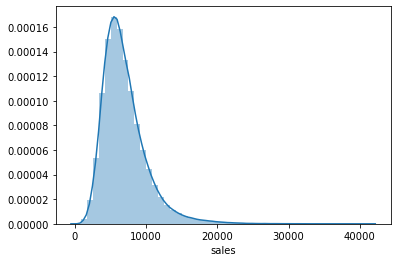

In [29]:
sns.distplot(df4['sales'])

### 4.1.2 Numerical Variable

<ipython-input-30-d3f6ed930134>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  num_attributes.hist(bins = 25, ax = fig.gca(), grid = False);


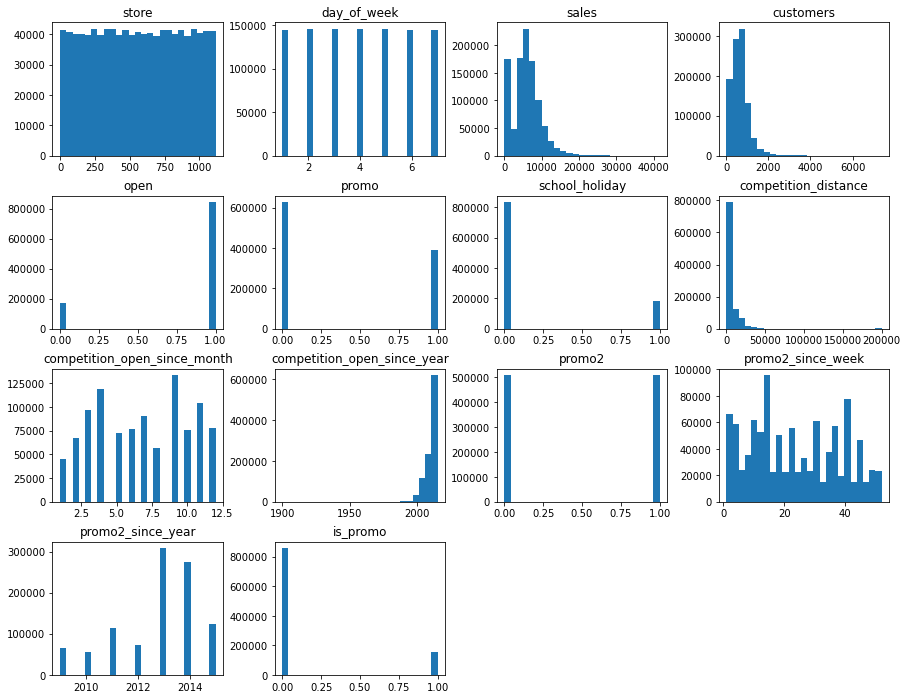

In [30]:
fig = plt.figure(figsize = (15,12))
num_attributes.hist(bins = 25, ax = fig.gca(), grid = False);

In [31]:
# create a list of the relation between each column with the sales.

### 4.1.3 Categorical Variable

<AxesSubplot:>

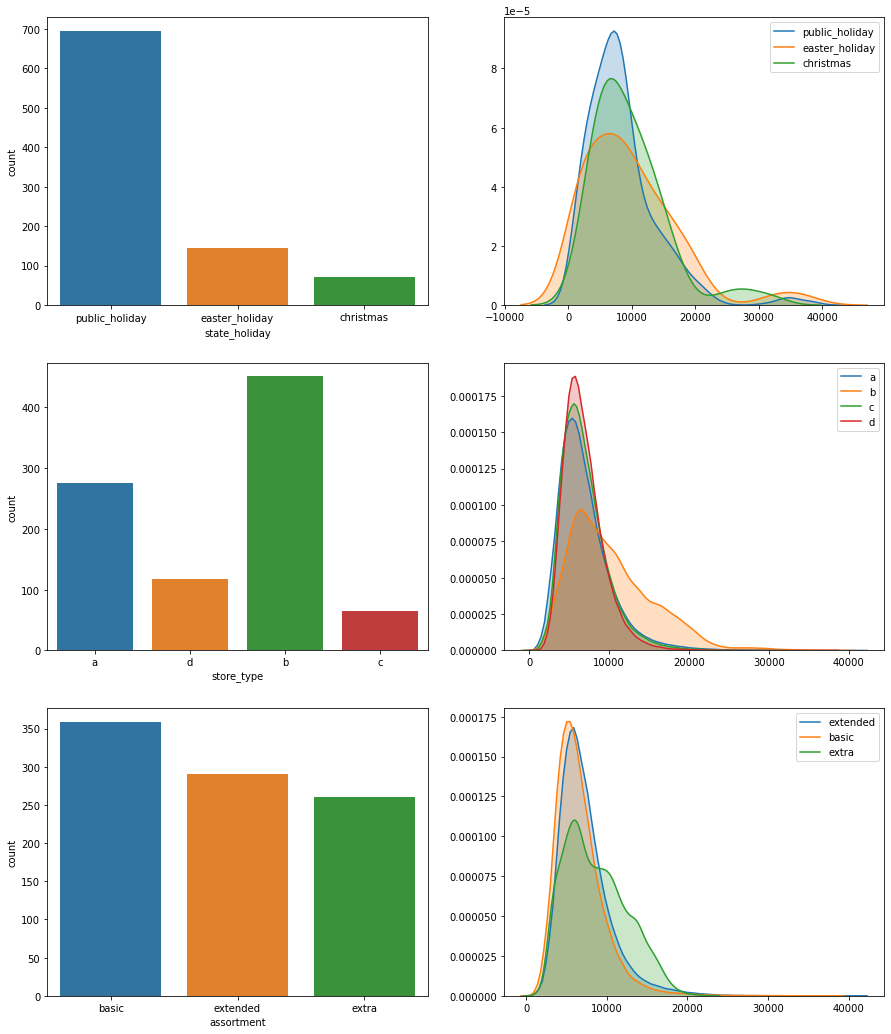

In [32]:
# satate_holiday
a = df4[df4['state_holiday'] != 'regular_day']
fig = plt.figure(figsize = (15,18))

plt.subplot (3,2,1)
sns.countplot(a['state_holiday'])

plt.subplot (3,2,2)
sns.kdeplot (df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot (df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
sns.kdeplot (df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True)

# store_type
plt.subplot (3,2,3)
sns.countplot(a['store_type'])

plt.subplot (3,2,4)
sns.kdeplot (df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot (df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot (df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot (df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)

# assortment
plt.subplot (3,2,5)
sns.countplot(a['assortment'])

plt.subplot (3,2,6)
sns.kdeplot (df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot (df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot (df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)

## 4.2 Bivariate Analysis

### H1: Stores with more assortment should have more sales.
**TRUE.** Stores with MORE ASSORTMENT have MORE SALES.

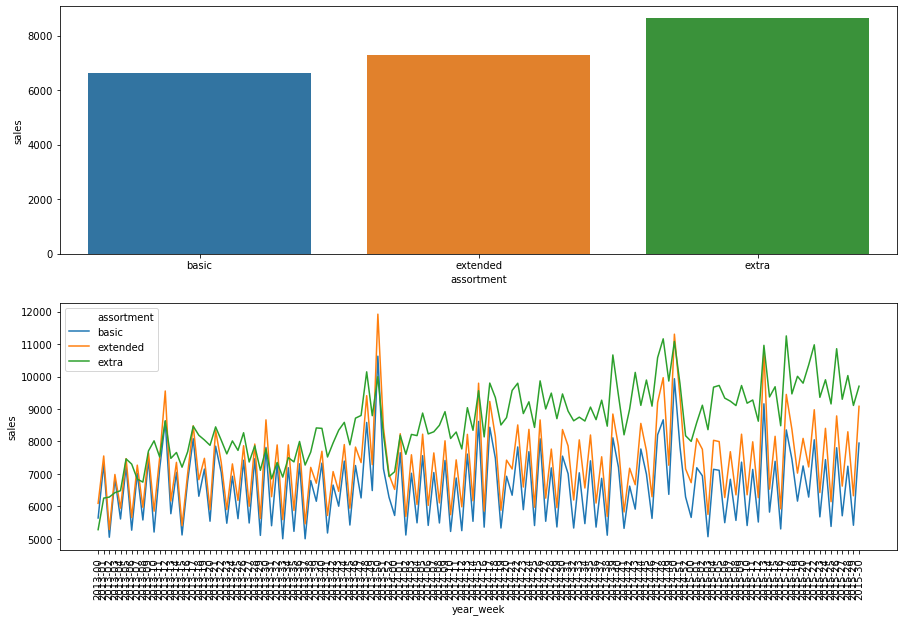

In [33]:
fig = plt.figure(figsize = (15,10))

plt.subplot (2,1,1)
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot (x = 'assortment', y = 'sales', data = aux1)

plt.subplot (2,1,2)
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).mean().reset_index()
#aux2.pivot (index = 'year_week', columns = 'assortment', values = 'sales').plot()
sns.lineplot(x='year_week', y='sales', hue='assortment', data = aux2)
plt.xticks(rotation = 90);

### H2: Stores with closer competitors should sell less.
**FALSE.** Stores with CLOSE COMPETITORS have almost igual sales.

<AxesSubplot:>

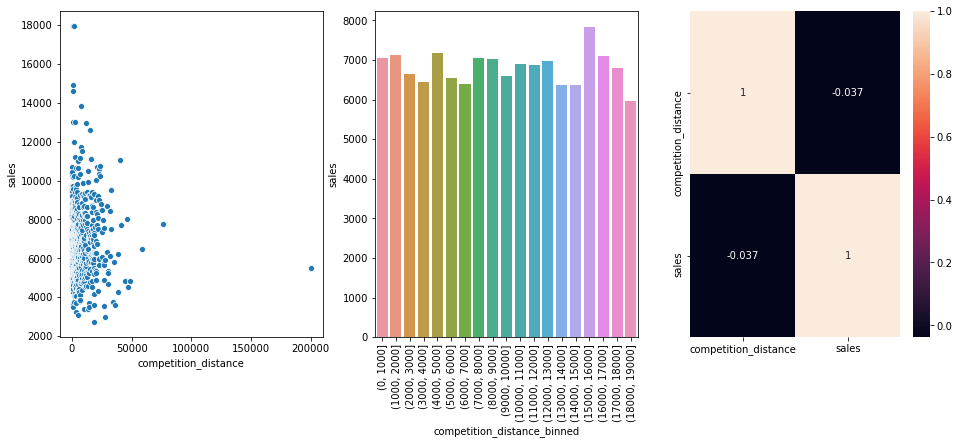

In [34]:
fig = plt.figure(figsize = (16,6))

plt.subplot (1,3,1)
aux1 = df4[['competition_distance', 'sales']].groupby ('competition_distance').mean().reset_index()
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1)

plt.subplot (1,3,2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut (aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby ('competition_distance_binned').mean().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2)
plt.xticks(rotation = 90);

plt.subplot (1,3,3)
sns.heatmap(aux1.corr(method= 'pearson'), annot = True)

### H3: Stores with longer competitors should sell more.
**FALSE.** Stores with LONGER COMPETITORS have LESS SALES.

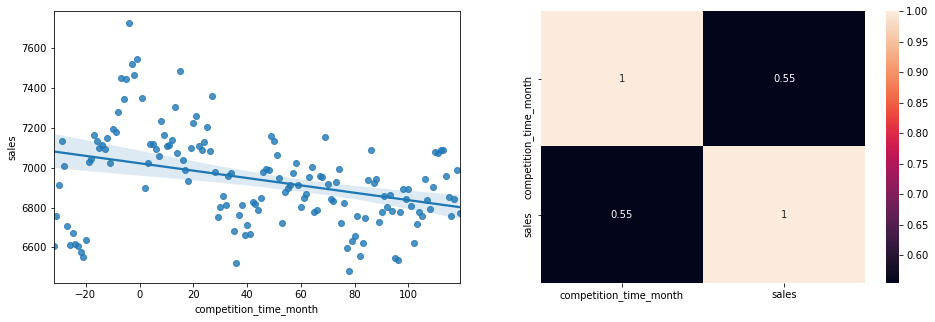

In [35]:
fig = plt.figure(figsize = (16,5))
grid = gridspec.GridSpec(1,2)

plt.subplot (grid[0,0])
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').mean().reset_index()
aux2 = aux1[(aux1['competition_time_month']<120) & (aux1['competition_time_month'] != 0)]
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot (grid[0,1])
sns.heatmap( aux1.corr( method = 'pearson'), annot = True)
plt.yticks( rotation = 90);

### H4: Stores that carry out extended promotions should sell more.
**TRUE.** Stores with active promotions for longer SELL MORE.

<AxesSubplot:>

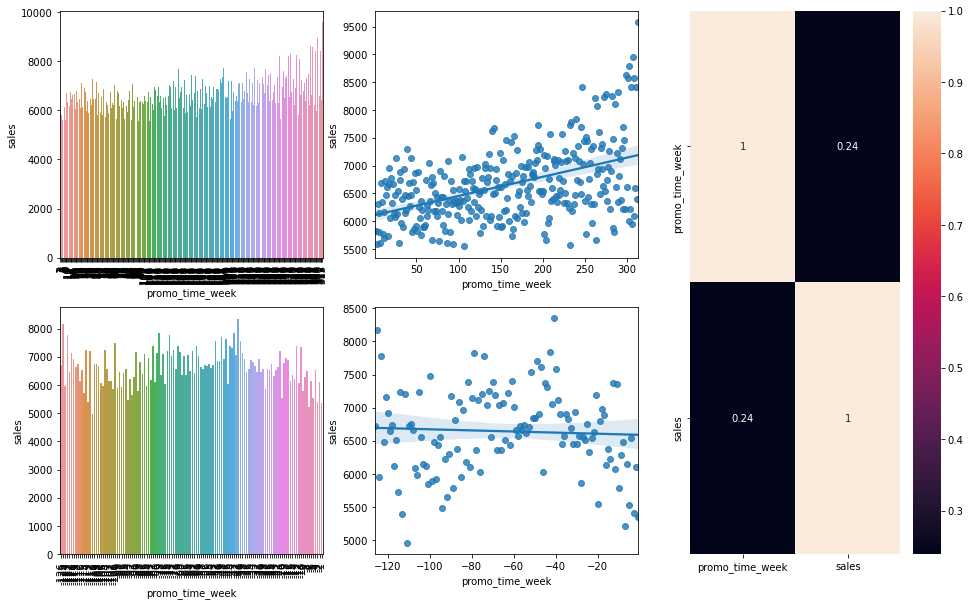

In [36]:
fig = plt.figure(figsize = (16,10))
grid = gridspec.GridSpec(2,3)

aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()

plt.subplot (grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # extended promotions
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2)
plt.xticks( rotation = 90);

plt.subplot (grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2)

plt.subplot (grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promotions
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3)
plt.xticks( rotation = 90);

plt.subplot (grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3)

plt.subplot (grid[:,2])
sns.heatmap(aux1.corr( method = 'pearson'), annot = True)

### H5: Stores with more days of promotions should sell more.
**TRUE** Stores with MORE DAYS of promotions SELL MORE, but the proportion of sales is higher during the 'promo'.

<AxesSubplot:>

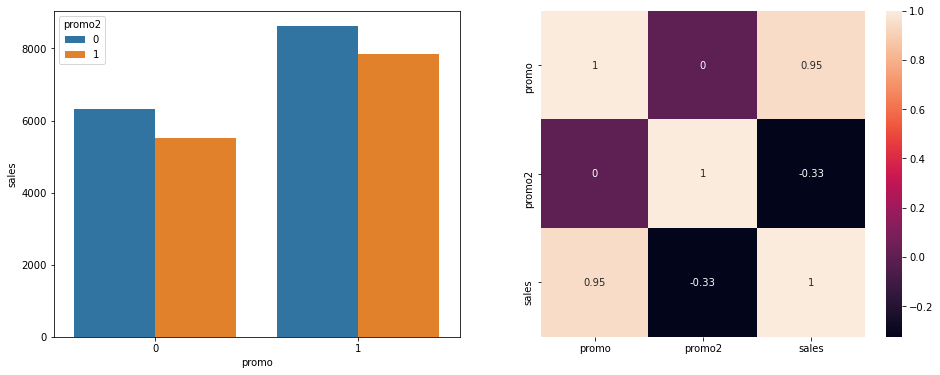

In [37]:
fig = plt.figure(figsize = (16,6))
aux1 = df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index()

plt.subplot (1,2,1)
sns.barplot(x = 'promo', y = 'sales', hue = 'promo2', data = aux1);

plt.subplot (1,2,2)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True)

### H6: Stores with more consecutive promotions should sell more.
**TRUE** Stores with more consecutive promotions SELL MORE.

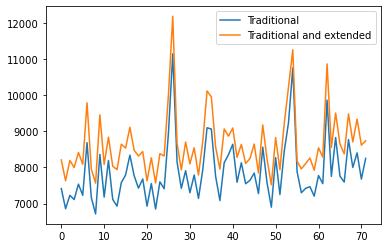

In [38]:
aux1 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 1 )][['year_week','sales']].groupby('year_week').mean().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 0 )][['year_week','sales']].groupby('year_week').mean().reset_index()
aux2.plot( ax = ax )

ax.legend( labels = ['Traditional', 'Traditional and extended']);

### H7: Stores open during the Christmas holiday should sell more.
**TRUE** Stores open during Crhistmas holiday sell more.

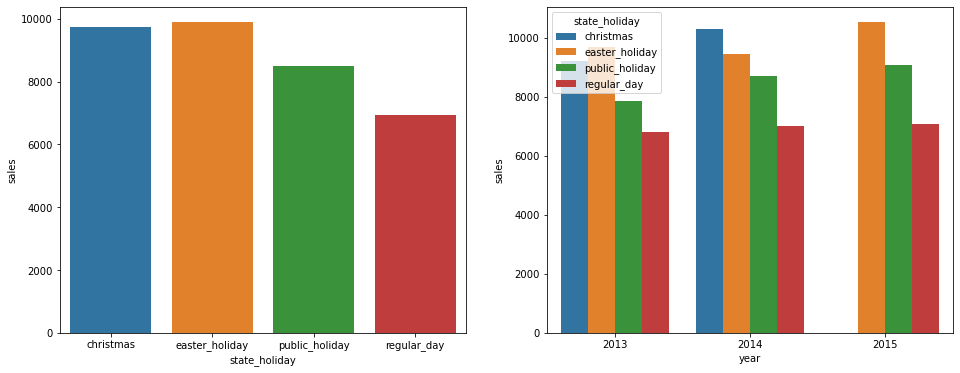

In [39]:
fig = plt.figure(figsize = (16,6))


plt.subplot(1,2,1)
aux1 = df4[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1,2,2)
aux2 = df4[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).mean().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2);

### H8: Older stores should sell more.
**FALSE** Older stores sell less.

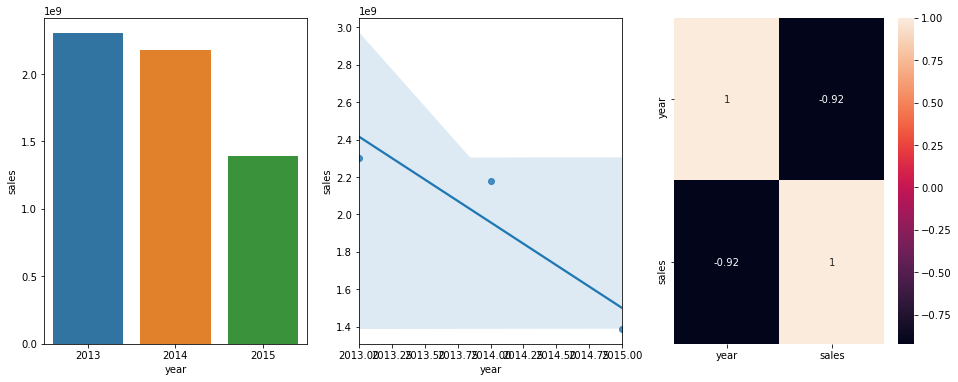

In [40]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
fig = plt.figure(figsize = (16,6))

plt.subplot(1,3,1)
sns.barplot( x = 'year', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'year', y ='sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

### H9: Stores should sell more in the second half of the year.
**TRUE** December is the month that sells the most.

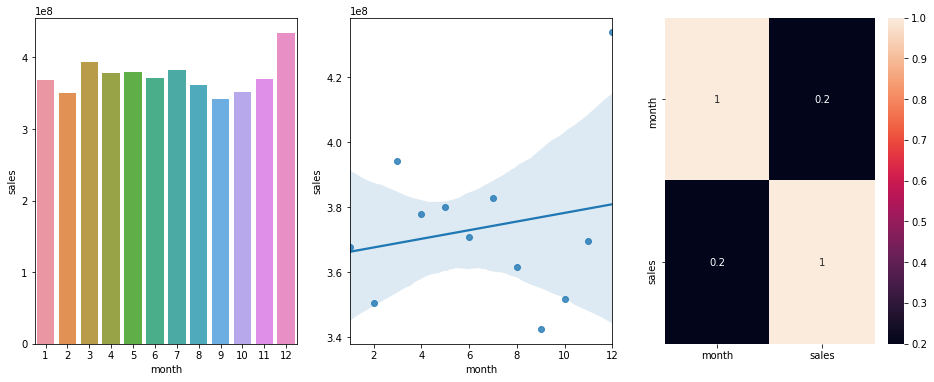

In [41]:
a = df4[df4['year'] != 2015]

aux1 = a[['month','sales']].groupby('month').sum().reset_index()
fig = plt.figure(figsize = (16,6))

plt.subplot(1,3,1)
sns.barplot( x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'month', y ='sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

### H10: Stores should sell more before the 10th day of each month.
**FALSE** Stores don't sell more before the 10th day of each month.

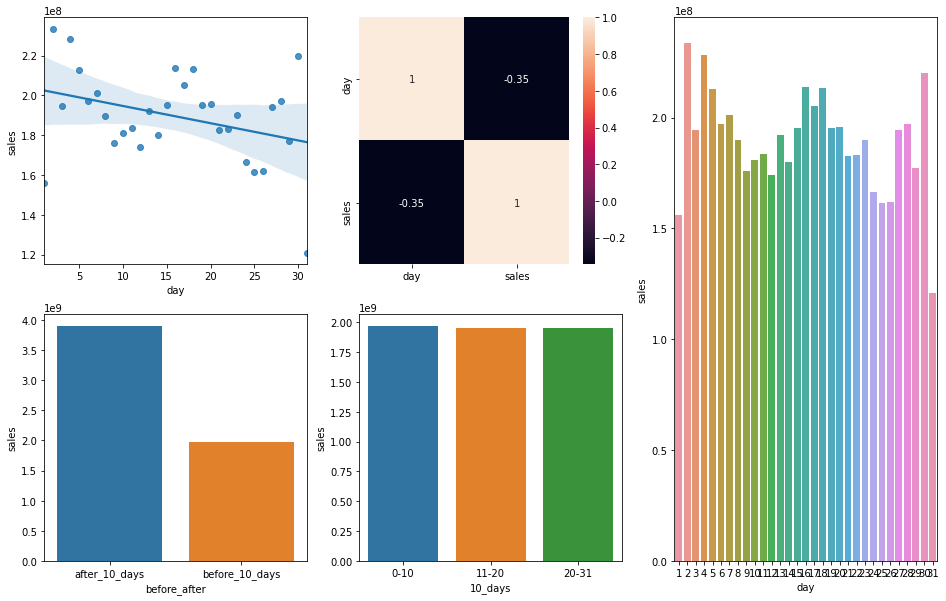

In [42]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
fig = plt.figure(figsize = (16,10))
grid = gridspec.GridSpec(2,3)

plt.subplot (grid[:,2])
sns.barplot( x = 'day', y = 'sales', data = aux1);

plt.subplot (grid[0,0])
sns.regplot(x = 'day', y ='sales', data = aux1);

plt.subplot (grid[0,1])
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

plt.subplot (grid[1,0])
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot( x = 'before_after', y = 'sales', data = aux2);

plt.subplot (grid[1,1])
aux1['10_days'] = aux1['day'].apply( lambda x: '0-10' if x <= 10 else ( '11-20' if 10<x<= 20 else '20-31'))
aux3 = aux1[['10_days','sales']].groupby('10_days').sum().reset_index()
sns.barplot( x = '10_days', y = 'sales', data = aux3);

### H11: Stores should sell less on weekends.
**TRUE** Stores sell less on weekends.

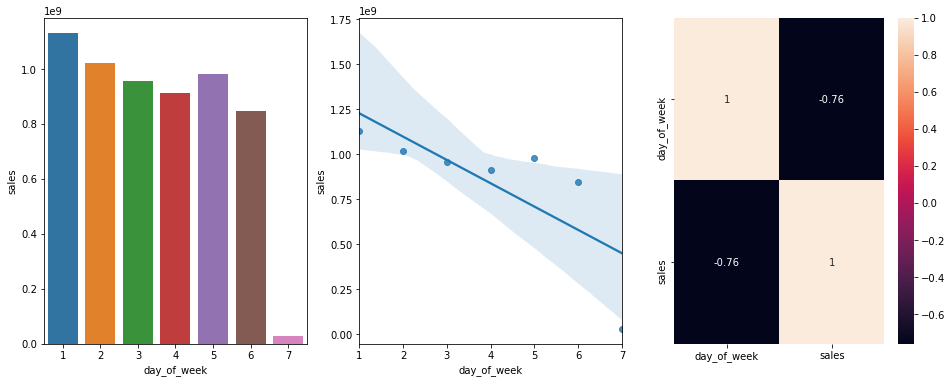

In [43]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
fig = plt.figure(figsize = (16,6))

plt.subplot(1,3,1)
sns.barplot( x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week', y ='sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

### H12: Stores should sell less during school holidays.
**FALSE** Stores sells more in holidays than in ordinary days.

Text(0.5, 1.0, 'Mean Sales per day')

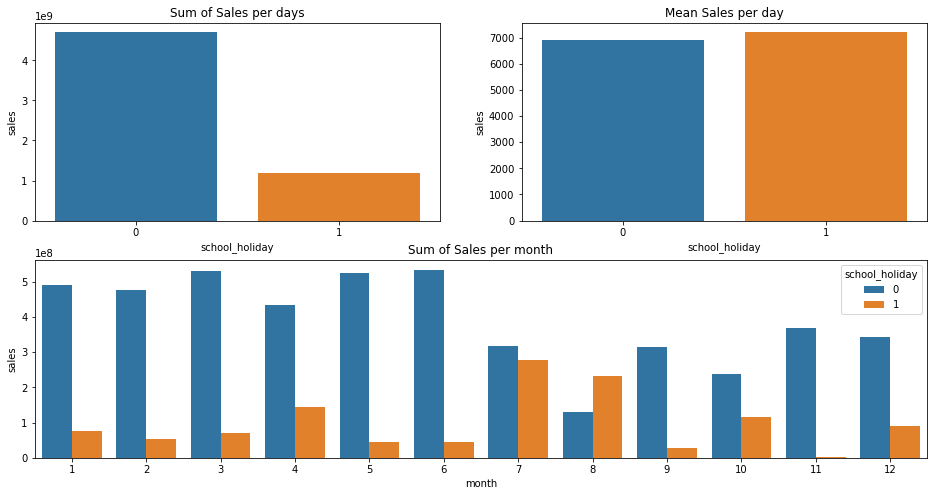

In [44]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
fig = plt.figure(figsize = (16,8))
grid = gridspec.GridSpec(2,2)

plt.subplot (grid[0,0])
sns.barplot( x = 'school_holiday', y = 'sales', data = aux1);
plt.title('Sum of Sales per days')

plt.subplot (grid[1,:])
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot( x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);
plt.title('Sum of Sales per month')

plt.subplot (grid[0,1])
aux3 = df4[['school_holiday','sales']].groupby('school_holiday').mean().reset_index()
sns.barplot( x = 'school_holiday', y = 'sales', data = aux3);
plt.title('Mean Sales per day')

### 4.2.1 Hypotheses resume

In [45]:
from tabulate import tabulate

In [46]:
tab = [['Hypotheses', 'Conclusion', 'Relevance'],
      ['H1', 'True', 'weak'],
      ['H2', 'False', 'weak'],
      ['H3', 'False', 'medium'],
      ['H4', 'True', 'weak'],
      ['H5', 'True', 'strong'],
      ['H6', 'True', 'medium'],
      ['H7', 'True', 'weak'],
      ['H8', 'False', 'strong'],
      ['H9', 'True', 'weak'],
      ['H10', 'False', 'medium'],
      ['H11', 'True', 'strong'],
      ['H12', 'False', 'strong'],]

print(tabulate(tab, headers = 'firstrow'))

Hypotheses    Conclusion    Relevance
------------  ------------  -----------
H1            True          weak
H2            False         weak
H3            False         medium
H4            True          weak
H5            True          strong
H6            True          medium
H7            True          weak
H8            False         strong
H9            True          weak
H10           False         medium
H11           True          strong
H12           False         strong


## 4.3 Multivariate Analysis

### Numerical Attributes

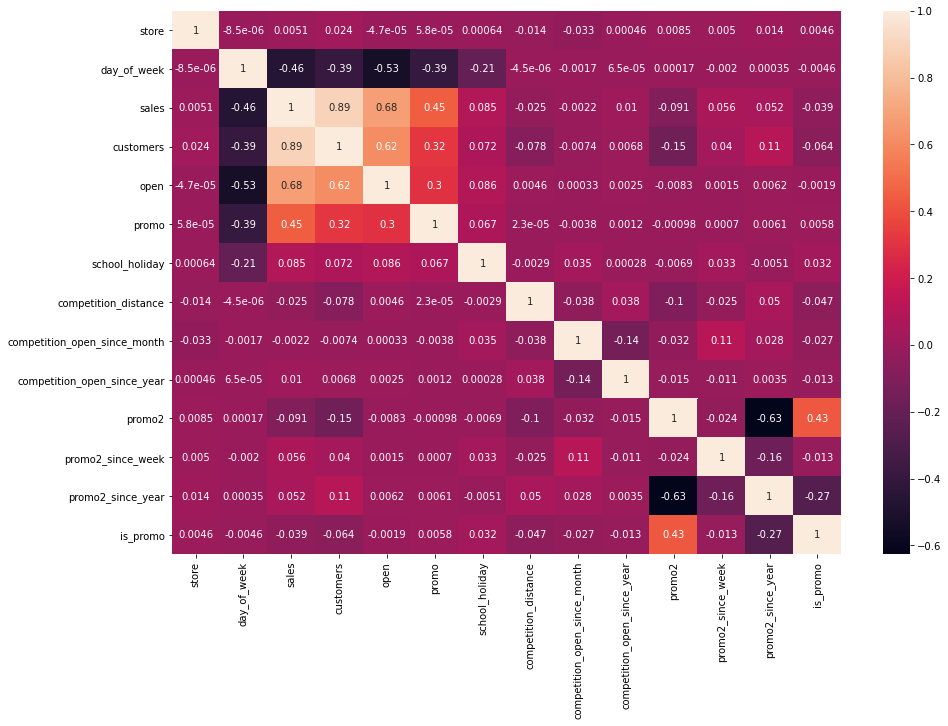

In [47]:
fig = plt.figure(figsize = (15,10))
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True);

### Categorical Attributes

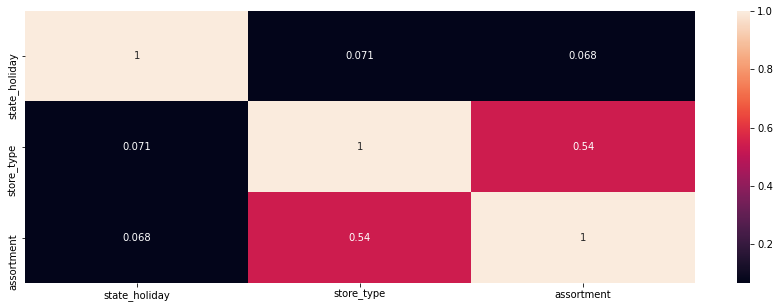

In [48]:
# Only categorical data
a = df4.select_dtypes( include = 'object')

# Calculate cramer v
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                   'store_type': [a4, a5, a6],
                   'assortment': [a7, a8, a9]})
d = d.set_index(d.columns)

fig = plt.figure(figsize = (15,5))
sns.heatmap(d, annot = True);

# 5.0 DATA PREPARATION

In [49]:
df5 = df4.copy()

## 5.1 Normalization of Features

None of the numerical variable have a normal distribution, thus the normalization it's not fit. 

## 5.2 Rescaling Features

In [50]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

## 5.3 Features Transformation

### 5.3.1 Encoding

In [51]:
# state holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix = ['state_holiday'], columns = ['state_holiday'] )

# store type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 Respose Variable Transformation

In [52]:
# Logarithm Transformation
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3 Nature Transformations

In [53]:
# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x* (2. * np.pi/30 )))
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x* (2. * np.pi/30 )))

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x* (2. * np.pi/12 )))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x* (2. * np.pi/12 )))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x* (2. * np.pi/7 )))
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x* (2. * np.pi/7 )))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x* (2. * np.pi/52 )))
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x* (2. * np.pi/52 )))

# 6.0 FEATURE SELECTION

In [54]:
df6 = df5.copy()

## 6.1 Split DataFrame into training and test DataSet

In [55]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis = 1 )

In [56]:
## we will separate the last 6 weeks for testing
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days = 6*7 )

Timestamp('2015-06-19 00:00:00')

In [57]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min date: {}'.format( X_train['date'].min()))
print('Training Max date: {}'.format( X_train['date'].max()))

print('\nTest Min date: {}'.format( X_test['date'].min()))
print('Test Max date: {}'.format( X_test['date'].max()))

Training Min date: 2013-01-01 00:00:00
Training Max date: 2015-06-18 00:00:00

Test Min date: 2015-06-19 00:00:00
Test Max date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature selector

In [58]:
# training and test dataset for boruta
#X_train_n = X_train.drop(['sales','date'], axis = 1).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs = -1 )

# define boruta
#boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit( X_train_n, y_train_n)

### 6.2.1 Best Features from Boruta

In [59]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis = 1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected Boruta
#cols_not_selected_boruta = list(np.setdiff1d( X_train_fs.columns, cols_selected_boruta ))

## 6.3 Manual Feature Selection

In [60]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_sin',
                        'day_cos',
                        'month_cos',
                        'month_sin',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

# columns to add:
feat_to_add = ['sales', 'date']

# columns full:
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 MACHINE LEARNING MODELLING

## 7.1 Evarage Model

In [61]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series data preparation
x_training = X_train[cols_selected_boruta_full]

In [62]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#predictiona
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns = {'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average_Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average_Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression

In [63]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [66]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose = False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [67]:
# model
lrr = Lasso( alpha = 0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451739


### 7.3.1 Linear Regression Regularized Model - Lasso - Cross Validation

In [69]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose = False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [70]:
# model
rf = RandomForestRegressor( n_estimators = 100, n_jobs = -1, random_state = 42  ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.741859,0.099843,1008.83426


   ### 7.4.1 Random Forest Regressor - Cross Validation

In [71]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest', rf, verbose = True )
rf_result_cv

/nKFold Number: 5
/nKFold Number: 4
/nKFold Number: 3
/nKFold Number: 2
/nKFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,838.56 +/- 219.67,0.12 +/- 0.02,1257.66 +/- 320.75


## 7.5 XGBoost Regressor

In [78]:
# model
model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                              n_estimators = 3000,
                              eta = 0.03,
                              max_depth = 5,
                              subsample = 0.3,
                              colsample_bytee = 0.9,
                              min_child_weight = 8).fit( x_train, y_train )


# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb))
xgb_result

[17:54:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,757.151747,0.113679,1089.22148


### 7.5.1 XGBoost Regressor - Cross Validation

In [79]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv

/nKFold Number: 5
[18:27:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


/nKFold Number: 4
[18:55:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


/nKFold Number: 3
[19:20:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bytee } might not be used.

  This

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,927.29 +/- 114.98,0.13 +/- 0.01,1320.76 +/- 158.64


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [75]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.741859,0.099843,1008.834260
0,XGBoost Regressor,757.151747,0.113679,1089.221480
0,Average_Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451739


### 7.6.2 Real Performance - Cross Validation

In [82]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,838.56 +/- 219.67,0.12 +/- 0.02,1257.66 +/- 320.75
0,XGBoost Regressor,927.29 +/- 114.98,0.13 +/- 0.01,1320.76 +/- 158.64
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


# 8.0 HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [86]:
import random
import warnings
warnings.filterwarnings( 'ignore' )

In [87]:
param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]}

MAX_EVAL = 5

In [88]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'], 
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'] )

    # performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] )
        
final_result

{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}
/nKFold Number: 5
/nKFold Number: 4
/nKFold Number: 3
/nKFold Number: 2
/nKFold Number: 1
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15}
/nKFold Number: 5
/nKFold Number: 4
/nKFold Number: 3
/nKFold Number: 2
/nKFold Number: 1
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}
/nKFold Number: 5
/nKFold Number: 4
/nKFold Number: 3
/nKFold Number: 2
/nKFold Number: 1
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}
/nKFold Number: 5
/nKFold Number: 4
/nKFold Number: 3
/nKFold Number: 2
/nKFold Number: 1
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15}
/nKFold Number: 5
/nKFold Number: 4
/nKFold Numb

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1796.01 +/- 198.84,0.25 +/- 0.01,2573.32 +/- 271.43
0,XGBoost Regressor,1245.59 +/- 138.22,0.17 +/- 0.01,1801.28 +/- 179.25
0,XGBoost Regressor,1052.76 +/- 139.38,0.15 +/- 0.01,1519.9 +/- 188.95
0,XGBoost Regressor,1038.81 +/- 137.61,0.14 +/- 0.01,1504.07 +/- 195.76
0,XGBoost Regressor,1575.78 +/- 170.4,0.22 +/- 0.01,2275.45 +/- 234.38
